In [3]:
path = 'src/data'
sys.path.append(path)
from dataLoader import loadDataframe

In [4]:
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)
#df_characters = loadDataframe('characters', path_to_directory)
df_clusters = loadDataframe('clusters', path_to_directory)
df_summaries = loadDataframe('summaries', path_to_directory)

c:\Users\blais\Documents\académique\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


### Geopanda adaptation data processing

The goal of this part is to fit the countries we can find in our film database with a world map that we can plot

In [5]:
from importlib import reload
import geopanda
reload(geopanda)

<module 'geopanda' from 'c:\\Users\\blais\\Documents\\académique\\ada-2024-project-teamcsx24\\./src/scripts\\geopanda.py'>

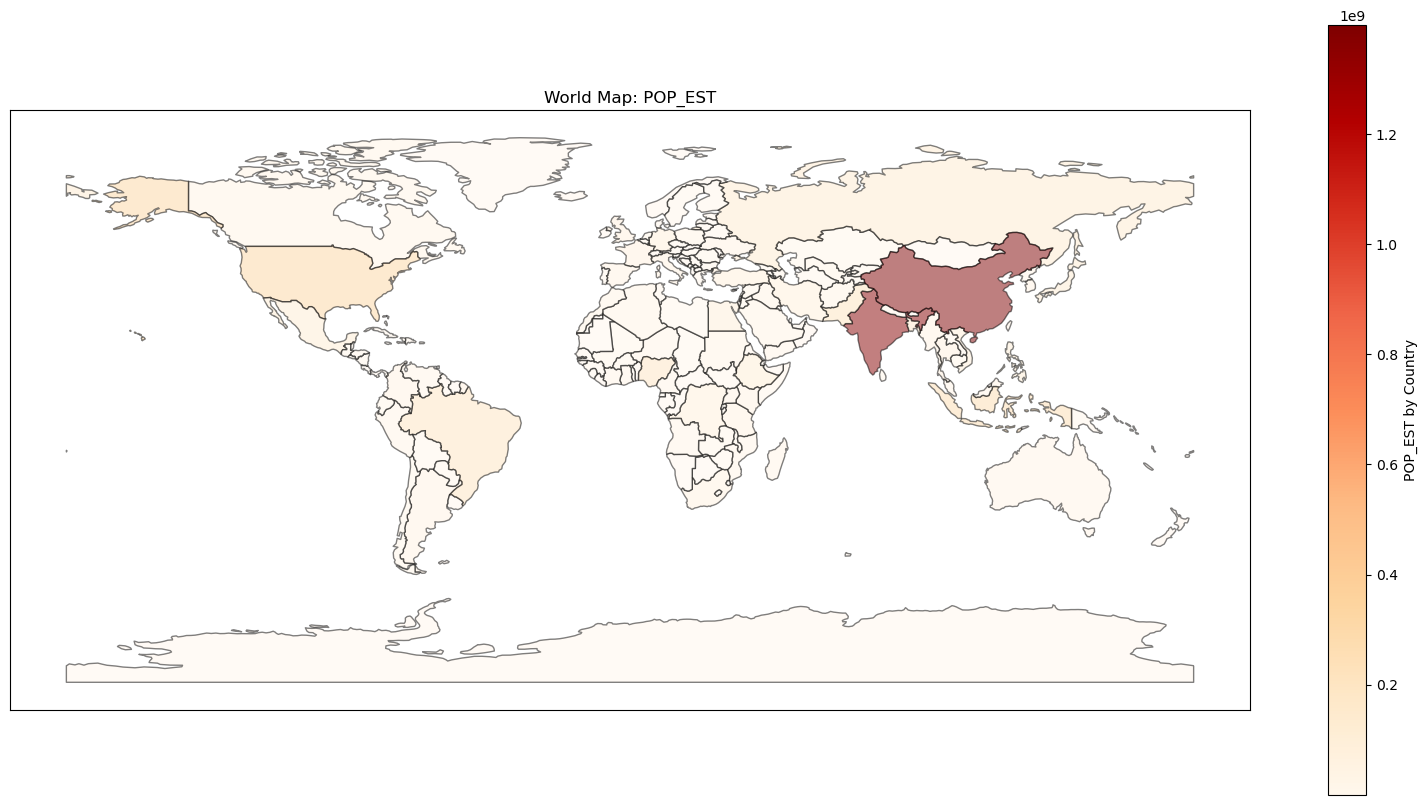

In [ ]:
#import the world dataset
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# We import the plot_world function from the geopanda.py script
import sys
sys.path.append('./src/scripts')
from geopanda import plot_world 

# load the world map from an external file
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# We use a function to plot the world map, this function is defined in the geopanda.py script
# The function takes the world dataset, and optionally the column to plot and the color map as arguments
plot_world(world, 'POP_EST', 'OrRd')


We decided to give an example of a plotted map with the population of each country, which is provided is the additional dataset

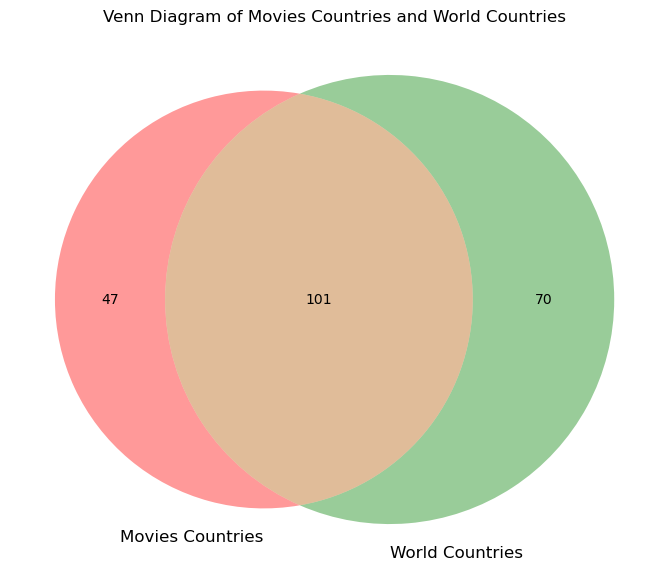

In [7]:
#Venn diagram of countries_dict.values() (in movies_cleaned) and world['SOVEREIGNT']
#ou bien Venn diagram entre movies_cleaned['country'] et world['SOVEREIGNT']

import json
from matplotlib_venn import venn2

# Extract the sets of unique countries from df_movies and world
movies_countries = set(df_movies['countries'].explode().unique())
world_countries = set(world['SOVEREIGNT'].unique())

#--------------------------------------------MAKE A FUNCTION--------------------------------------------

# Plot the Venn diagram
plt.figure(figsize=(10, 7))
venn2([movies_countries, world_countries], ('Movies Countries', 'World Countries'))
plt.title("Venn Diagram of Movies Countries and World Countries")
plt.show()
#--------------------------------------------------------------------------------------------------------


We could expect that some countries had never published any film, but the fact that some of our films don't find any matching country on our map is going to be a problem. Thus we should explore which cases are a problem and how we could solve it.

In [8]:
# Find the countries that are in df_movies but not in world
countries_not_in_world = movies_countries - world_countries

# Print the result
print(countries_not_in_world)


{'Malta', 'Bahamas', 'Czech Republic', 'Bahrain', 'Malayalam Language', 'Nazi Germany', 'Aruba', 'Kingdom of Great Britain', 'Republic of China', 'Republic of Macedonia', 'Puerto Rico', 'Mandatory Palestine', 'Serbia and Montenegro', 'Northern Ireland', 'Korea', 'German Democratic Republic', 'Yugoslavia', 'Palestinian territories', 'Slovak Republic', 'Ukranian SSR', 'Monaco', 'Georgian SSR', nan, 'Weimar Republic', 'Socialist Federal Republic of Yugoslavia', 'Soviet Union', 'Uzbek SSR', 'Kingdom of Italy', 'England', 'Soviet occupation zone', 'West Germany', 'Hong Kong', 'Scotland', 'Palestinian Territories', 'Crime', 'Isle of Man', 'German Language', 'Congo', 'Ukrainian SSR', 'Serbia', 'Macau', 'Burma', 'Czechoslovakia', 'Iraqi Kurdistan', 'Federal Republic of Yugoslavia', 'Singapore', 'Wales'}


We observe that three main problems appear : 
- Many film countries are named under old countries names such as 'Kingdom of Italy'
- Some countries don't exist in the geopanda map, such as Singapore
- Some countries have multiple names such as 'Czech Republic' and 'Czechia'

To solve these problems, we report some of the film countries to some existing one in the geopanda map (for example we associate every country name that refers to the same one to the geopanda name, and associate any small country to the closest bigger one).

In [10]:
from geopanda import replace_countries

with open('data/freebaseIdDictionnaries/countries', 'r') as file:
    countries_dict = json.load(file)

geo_countries_dict = replace_countries(countries_dict)

#save the dictionary just like arnaud did

Now we have a uniform dictionnary to rely the freebase Id with its actual country, it could also be useful for some other features.

### Languages study by country

In [ ]:
with open('data/freebaseIdDictionnaries/languages', 'r') as file:
    languages_dict = json.load(file)

#
#df_movies['countries_freebase_id'] = df_movies['countries_freebase_id'].apply(eval)

# Explode the lists in 'countries_freebase_id' and 'languages_freebase_id' columns
movies_df_exploded = df_movies.explode('countries_freebase_id').explode('languages_freebase_id')

# Group by 'countries_freebase_id' and count unique 'languages_freebase_id'
max_languages_per_country = movies_df_exploded.groupby('countries_freebase_id')['languages_freebase_id'].nunique()

# Order the result from biggest to smallest
max_languages_per_country_sorted = max_languages_per_country.sort_values(ascending=False)

# Map the index to country names using countries_dict
max_languages_per_country_sorted.index = max_languages_per_country_sorted.index.map(countries_dict.get)

#print the index of max_languages_per_country_sorted
print(max_languages_per_country_sorted)

countries_freebase_id
United States of America    622
France                      428
Germany                     369
United Kingdom              334
Italy                       176
                           ... 
Germany                       1
Iraq                          1
Israel                        1
Russia                        1
Guinea-Bissau                 1
Name: languages_freebase_id, Length: 147, dtype: int64
